In [1]:
import os
import numpy as np
import PIL
from PIL import Image
#import PIL.Image
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
from sklearn.model_selection import train_test_split
%matplotlib inline

from tensorflow.keras.preprocessing.image import ImageDataGenerator 
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.layers import Dense, Input, Dropout,Flatten, Conv2D, ZeroPadding2D
from tensorflow.keras.layers import BatchNormalization, Activation, MaxPooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array

from IPython.display import SVG, Image
from livelossplot import PlotLossesKerasTF
import tensorflow as tf
print("Tensorflow version:", tf.__version__)
print(PIL.__version__)


import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.python.keras import Sequential
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
from IPython.display import display
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras import optimizers

Tensorflow version: 2.4.0-dev20200724
7.1.2


In [2]:
#Get training set and test set directories

train_dir = '/Users/rakshitdwivedi/Desktop/AI/ASL_Model/train/asl_alphabet_train'
test_dir = '/Users/rakshitdwivedi/Desktop/AI/ASL_Model/test/asl_alphabet_test!'

print('total training images' , len(os.listdir(train_dir)))
print('total test images', len(os.listdir(test_dir)))
    

total training images 30
total test images 29


In [3]:
#Display the first 10 labels 

train_fnames = os.listdir( train_dir )
test_fnames = os.listdir( test_dir )

print(train_fnames[:10])
print(test_fnames[:10])    

['.DS_Store', 'R', 'U', 'I', 'N', 'G', 'Z', 'T', 'S', 'A']
['.DS_Store', 'R', 'U', 'I', 'N', 'G', 'Z', 'T', 'S', 'A']


In [4]:
#Display total number of images on each label

for alpha in os.listdir(train_dir):
    print(str(len(os.listdir(train_dir))) + " " + alpha + " images")

30 .DS_Store images
30 R images
30 U images
30 I images
30 N images
30 G images
30 Z images
30 T images
30 S images
30 A images
30 F images
30 O images
30 H images
30 del images
30 nothing images
30 space images
30 M images
30 J images
30 C images
30 D images
30 V images
30 Q images
30 X images
30 E images
30 B images
30 K images
30 L images
30 Y images
30 P images
30 W images


In [5]:
#Written to solve the error for .DSstore

def mylistdir(directory):
    """A specialized version of os.listdir() that ignores files that
    start with a leading period."""
    filelist = os.listdir(directory)
    return [x for x in filelist
            if not (x.startswith('.'))]

unique_labels =  ['R', 'U', 'I', 'N', 'G', 'Z', 'T', 'S', 'A', 'F', 'O', 'H', 'del', 'nothing', 'space', 'M', 'J', 'C', 'D', 'V', 'Q', 'X', 'E', 'B', 'K', 'L', 'Y', 'P', 'W']


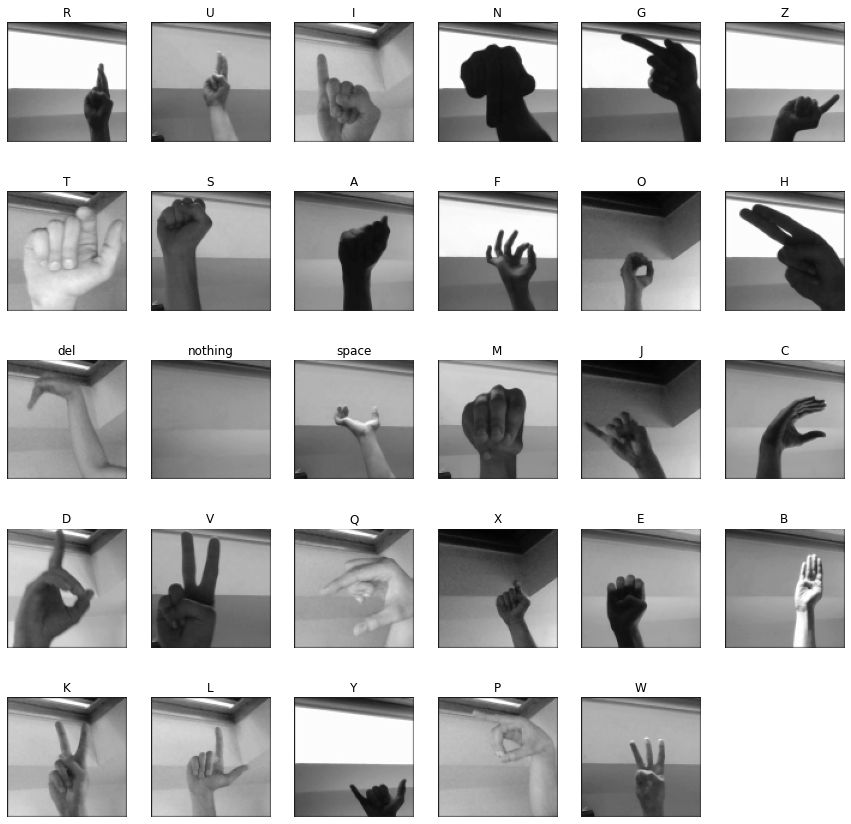

In [6]:
#Load unique images for display

def load_unique():
    size_img = 100,100 
    images_for_plot = []
    labels_for_plot = []
    for folder in mylistdir(train_dir):
        for file in mylistdir(train_dir + '/' + folder):
            filepath = train_dir + '/' + folder + '/' + file
            image = cv2.imread(filepath)
            final_img = cv2.resize(image, size_img)             
            final_img = cv2.cvtColor(final_img, cv2.COLOR_BGR2GRAY)
            final_img = final_img.reshape(final_img.shape + (1,))
            images_for_plot.append(final_img)
            labels_for_plot.append(folder)
            break
    return images_for_plot, labels_for_plot

images_for_plot, labels_for_plot = load_unique()
print("unique_labels = ", labels_for_plot)

fig = plt.figure(figsize = (15,15))
def plot_images(fig, image, label, row, col, index):
    fig.add_subplot(row, col, index)
    plt.axis('off')
    #plt.imshow(image)
    plt.imshow(image, cmap='gray', vmin = 0, vmax = 255)
    plt.title(label)
    return

image_index = 0
row = 5
col = 6
for i in range(1,(row*col)):
    plot_images(fig, images_for_plot[image_index], labels_for_plot[image_index], row, col, i)
    image_index = image_index + 1
plt.show()

In [7]:
#Load data onto the machine for training

labels_dict = {'A':0,'B':1,'C':2,'D':3,'E':4,'F':5,'G':6,'H':7,'I':8,'J':9,'K':10,'L':11,'M':12,
                   'N':13,'O':14,'P':15,'Q':16,'R':17,'S':18,'T':19,'U':20,'V':21,'W':22,'X':23,'Y':24,
                   'Z':25,'space':26,'del':27,'nothing':28}

def load_data():
    """
    Loads data and preprocess. Returns train and test data along with labels.
    """
    images = []
    labels = []
    size = 100,100
    print("LOADING DATA FROM : ",end = "")
    for folder in mylistdir(train_dir):
        print(folder, end = ' | ')
        for image in mylistdir(train_dir + "/" + folder):
            temp_img = cv2.imread(train_dir + '/' + folder + '/' + image)
            temp_img = cv2.resize(temp_img, size)
            temp_img = cv2.cvtColor(temp_img, cv2.COLOR_BGR2GRAY)
            temp_img = temp_img.reshape(temp_img.shape + (1,))
            images.append(temp_img)
            labels.append(labels_dict[folder])
    
    images = np.array(images)
    images = images.astype('float32')/255.0
    
    labels = tf.keras.utils.to_categorical(labels)
    
    
    
    X_train, X_test, Y_train, Y_test = train_test_split(images, labels, test_size = 0.20)
    
    
    print()
    print('Loaded', len(X_train),'images for training,','Train data shape =',X_train.shape)
    print('Loaded', len(X_test),'images for testing','Test data shape =',X_test.shape)
    
    return X_train, X_test, Y_train, Y_test

In [8]:
X_train, X_test, Y_train, Y_test = load_data()

LOADING DATA FROM : R | U | I | N | G | Z | T | S | A | F | O | H | del | nothing | space | M | J | C | D | V | Q | X | E | B | K | L | Y | P | W | 
Loaded 69600 images for training, Train data shape = (69600, 100, 100, 1)
Loaded 17400 images for testing Test data shape = (17400, 100, 100, 1)


In [9]:
# #______________________________________________CNN network_________________________________________________________

model = tf.keras.models.Sequential([

#1st layer
tf.keras.layers.Conv2D(32,(3,3), padding = 'same', input_shape = (100,100,1)),
tf.keras.layers.Activation('relu'),
tf.keras.layers.MaxPooling2D(pool_size = (2,2)),


#2nd layer
tf.keras.layers.Conv2D(64,(3,3), padding = 'same'),
tf.keras.layers.Activation('relu'),
tf.keras.layers.MaxPooling2D(pool_size = (2,2)),

tf.keras.layers.Dropout(0.5),


#3rd layer
tf.keras.layers.Conv2D(128,(2,2), padding = 'same'),
tf.keras.layers.Activation('relu'),
tf.keras.layers.MaxPooling2D(pool_size = (2,2)),

    
#4th layer
tf.keras.layers.Conv2D(256,(2,2), padding = 'same'),
tf.keras.layers.Activation('relu'),
tf.keras.layers.MaxPooling2D(pool_size = (2,2)),
    



          
#Flatten
tf.keras.layers.Flatten(),
tf.keras.layers.Dropout(0.25),
tf.keras.layers.BatchNormalization(),
          
#FullyConnected 1st layer
tf.keras.layers.Dense(128),
tf.keras.layers.Activation('relu'),
        


    

          
tf.keras.layers.Dense(29, activation='softmax')
          
])
          
opt = Adam(lr=0.0001)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 100, 100, 32)      320       
_________________________________________________________________
activation (Activation)      (None, 100, 100, 32)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 50, 50, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 50, 50, 64)        18496     
_________________________________________________________________
activation_1 (Activation)    (None, 50, 50, 64)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 25, 25, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 25, 25, 64)        0

In [10]:
# from tensorflow.keras import datasets, layers, models
# CNN = models.Sequential()

# CNN.add(layers.Conv2D(6, (5,5), activation = 'relu', input_shape = (100, 100,1)))
# CNN.add(layers.AveragePooling2D())

# CNN.add(layers.Dropout(0.20))

# CNN.add(layers.Conv2D(16, (5,5), activation = 'relu'))
# CNN.add(layers.AveragePooling2D())


# CNN.add(layers.Flatten())

# CNN.add(layers.Dense(1024, activation = 'relu'))
# CNN.add(layers.Dense(512, activation = 'relu'))
# CNN.add(layers.Dense(29, activation = 'softmax'))
# CNN.summary()



In [11]:
# CNN.compile(optimizer = 'Adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [12]:
#Callbacks and model compilation

# %%time

epochs = 10
batch_size = 64
checkpoint = ModelCheckpoint("asl_model_saved.h5", monitor='val_accuracy',
                             save_weights_only=False, mode='max', verbose=1)

callbacks = [PlotLossesKerasTF(), checkpoint]

def fit_model():
    history = model.fit(X_train, Y_train, batch_size = batch_size, epochs = epochs, validation_split = 0.1, callbacks= callbacks, verbose= 1)
    return history

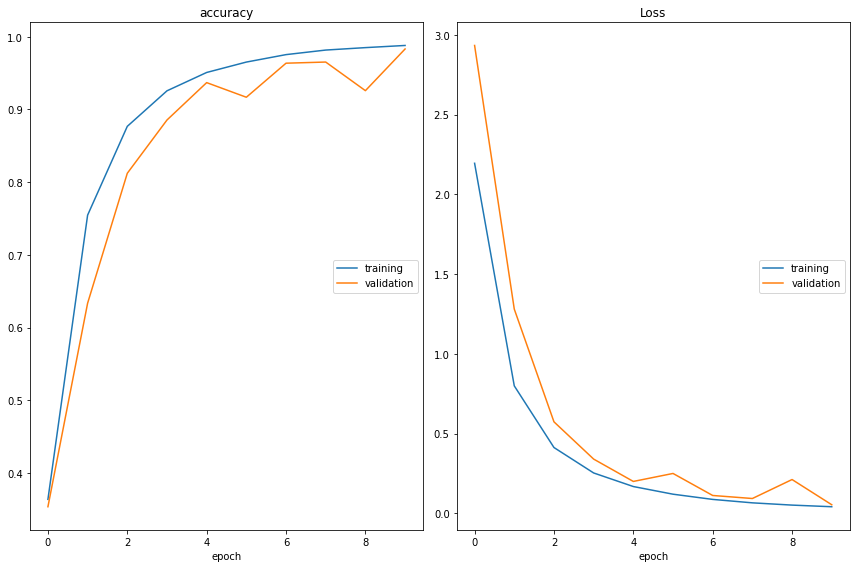

accuracy
	training         	 (min:    0.364, max:    0.988, cur:    0.988)
	validation       	 (min:    0.353, max:    0.983, cur:    0.983)
Loss
	training         	 (min:    0.042, max:    2.194, cur:    0.042)
	validation       	 (min:    0.055, max:    2.933, cur:    0.055)

Epoch 00010: saving model to asl_model_saved.h5
979/979 [==============================] - 591s 604ms/step - loss: 0.0450 - accuracy: 0.9873 - val_loss: 0.0546 - val_accuracy: 0.9832


In [13]:
curr_model = fit_model()

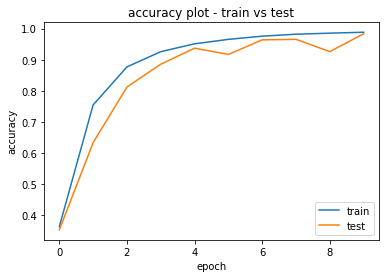

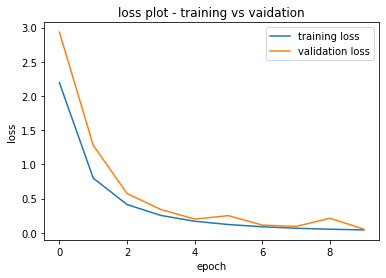

In [14]:
#Plotting the data

plt.plot(curr_model.history['accuracy'])
plt.plot(curr_model.history['val_accuracy'])
plt.legend(['train', 'test'], loc='lower right')
plt.title('accuracy plot - train vs test')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

plt.plot(curr_model.history['loss'])
plt.plot(curr_model.history['val_loss'])
plt.legend(['training loss', 'validation loss'], loc = 'upper right')
plt.title('loss plot - training vs vaidation')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

In [15]:
evaluate_metrics = model.evaluate(X_test, Y_test)
print("\nEvaluation Accuracy = ", "{:.2f}%".format(evaluate_metrics[1]*100),"\nEvaluation loss = " ,"{:.6f}".format(evaluate_metrics[0]))

544/544 [==============================] - 39s 72ms/step - loss: 0.0574 - accuracy: 0.9818

Evaluation Accuracy =  98.18% 
Evaluation loss =  0.057374


In [22]:
#Load data onto the machine for testing

def load_test_data():
    images = []
    names = []
    size = 100,100
    for image in mylistdir(test_dir):
        for file in mylistdir(test_dir + '/' + image):
            fpath = test_dir + '/' + image + '/' + file
            temp = cv2.imread(fpath)
            
        try:
            temp = cv2.resize(temp, size, cv2.INTER_AREA)
            temp = cv2.cvtColor(temp, cv2.COLOR_BGR2GRAY)
            temp = temp.reshape(temp.shape + (1,))
            
        except cv2.error as e:
            print('your images are done bro!')
        cv2.waitKey()
        images.append(temp)
        names.append(image)
    images = np.array(images)
    images = images.astype('float32')/255.0
    return images, names

test_images, test_img_names = load_test_data()

In [23]:
predictions = [model.predict_classes(image.reshape(1,100,100,1))[0] for image in test_images]

In [24]:
def get_labels_for_plot(predictions):
    predictions_labels = []
    for i in range(len(predictions)):
        for ins in labels_dict:
            if predictions[i] == labels_dict[ins]:
                predictions_labels.append(ins)
                break
    return predictions_labels

predictions_labels_plot = get_labels_for_plot(predictions)

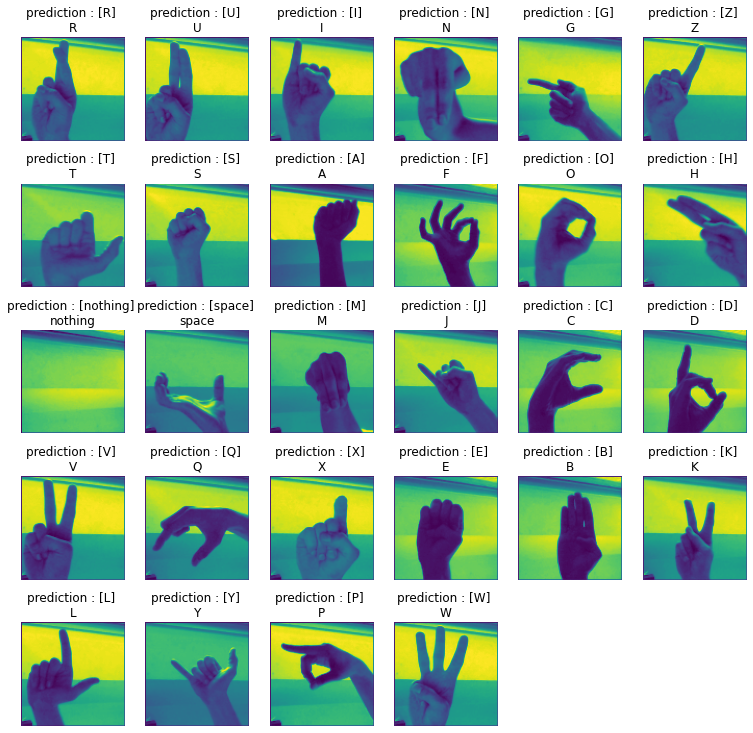

In [25]:
predfigure = plt.figure(figsize = (13,13))
def plot_image_1(fig, image, label, prediction, predictions_label, row, col, index):
    fig.add_subplot(row, col, index)
    plt.axis('off')
    plt.imshow(image)
    title = "prediction : [" + str(predictions_label) + "] "+ "\n" + label
    plt.title(title)
    return

image_index = 0
row = 5
col = 6
for i in range(1,(row*col-1)):
    plot_image_1(predfigure, test_images[image_index], test_img_names[image_index], predictions[image_index], predictions_labels_plot[image_index], row, col, i)
    image_index = image_index + 1
plt.show()

In [21]:
model_json = model.to_json()
with open("asl_model.json", "w") as json_file:
    json_file.write(model_json)

In [4]:
import tensorflow as tf

keras_model = tf.keras.models.load_model("asl_model_saved.h5")
converter = tf.lite.TFLiteConverter.from_keras_model(keras_model)
tflite_model = converter.convert()

# Save the model.
with open('asl-model.tflite', 'wb') as f:
    f.write(tflite_model)
  

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: /var/folders/cc/bd64ngz93jl87v59rw_5fb8m0000gn/T/tmpr5z6h1mr/assets
